In [3]:
import pandas as pd
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

import statsmodels.api as sm
from scipy import stats

#df_emotion_and_LIWC = pd.read_csv("LIWC_and_emotions.csv")

In [56]:
#df_time_adj = pd.read_csv("LIWC2015 Results (previous_reviews.csv).csv")
#df_time_adj.rename(columns={'K':'originalRevID','A': 'date', 'B': 'reviewID', 'C':'reviewerID', 'D': 'review', 'E': 'rating', 'F':'usefulCount', 'G':'coolCount','H':'funnyCount', 'I': 'flagged','J': 'restaurantID'}, inplace=True)
#df_time_adj=df_time_adj.drop(0)

/Users/jamesfyfe/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [223]:
############### Making a balanced dataframe #################
random.seed(1)

df_emotion = pd.read_csv("LIWC_and_emotions.csv")
#df_LIWC = pd.read_csv("LIWC2015 Results (previous_reviews.csv).csv")
df_time_adj  = pd.read_csv("time_adjusted_LIWC_and_emotions.csv")
#df_emotion_and_LIWC = pd.merge()

#pos = (df_emotion_and_LIWC[df_emotion_and_LIWC["flagged"]=="Y"])
#neg= (df_emotion_and_LIWC[df_emotion_and_LIWC["flagged"]=="N"])
#df_neg_only = neg.sample(n=len(pos), random_state =1)
#df_pos_only = pos.sample(n=1500, random_state =1)
#pd.merge(df_time_adj,df_emotion, left_on='originalRevID', right_on='reviewID')


#df_emotion = pd.concat([df_neg_only, pos])
#df_LIWC.info()
df_time_adj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29105 entries, 0 to 29104
Data columns (total 48 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reviewID       29104 non-null  object 
 1   sadness        29105 non-null  float64
 2   anger          29105 non-null  float64
 3   disgust        29105 non-null  float64
 4   joy            29105 non-null  float64
 5   fear           29105 non-null  float64
 6   date           29105 non-null  object 
 7   reviewerID     29105 non-null  object 
 8   review         29105 non-null  object 
 9   rating         29105 non-null  int64  
 10  usefulCount    29105 non-null  int64  
 11  coolCount      29105 non-null  int64  
 12  funnyCount     29105 non-null  int64  
 13  flagged        29105 non-null  object 
 14  restaurantID   29105 non-null  object 
 15  originalRevID  29105 non-null  object 
 16  WC             29105 non-null  int64  
 17  Analytic       29105 non-null  float64
 18  Clout 

In [224]:
#df_time_adj=df_time_adj.sort_values(["originalRevID","date"], ascending=False).groupby("originalRevID").head(5)


In [225]:
df_time_adj.rename(columns={'anger_y':'anger_LIWC', "sadness":"priorSadness","anger":"priorAnger",
                        "fear":"priorFear","disgust":"priorDisgust",
                        "joy":"priorJoy"}, inplace=True)

df_temp = df_time_adj.drop(columns=["flagged","reviewerID","reviewID","restaurantID","review"])
df_temp.rename(columns={'originalRevID':'reviewID','anger':'anger_LIWC'}, inplace=True)

In [226]:
#df_temp = df_time_adj[["date", "reviewID","rating","Tone","Analytic","Clout","Authentic","WC"]]

df_temp.rating = df_temp.rating.astype(float)
df_time_adjusted_features = df_temp.groupby("reviewID").mean().reset_index()

In [227]:
df_time_adjusted_features.rename(columns={'rating': 'priorRating',
                                          'Tone': 'priorTone', 
                                          'Clout':'priorClout',
                                          'Analytic':'priorAnalytic', 
                                          'Authentic': 'priorAuthentic',
                                          'WC': 'priorWC',
                                          'i':'priorI',
                                          'we':'priorWe',
                                          'you':'priorYou',
                                          'shehe':'priorShehe',
                                          'ipron':'priorIpron',
                                          'they':'priorThey'}, inplace=True)


In [228]:
df_base = df_emotion
#df_base

In [229]:
df_combined = pd.merge(df_time_adjusted_features,df_base, on="reviewID")

In [235]:
import sqlite3

def connect_db(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn

conn = connect_db("/Users/jamesfyfe/summer vac misc/yelpResData.db")
cur = conn.cursor()


res_ids = tuple(df_combined["restaurantID"].unique())
query = "SELECT restaurantID,rating FROM restaurant WHERE restaurantID in {}".format(res_ids)
cur.execute(query)
res_ratings = cur.fetchall()

In [248]:
df_res = pd.DataFrame(res_ratings).rename(columns={1:"resRating",0:"restaurantID"})
df_combined = pd.merge(df_combined,df_res, on="restaurantID")

In [249]:
df_combined["ratingDiff"] = np.abs(df_combined["rating"] - df_combined["priorRating"])
df_combined["AnalyticDiff"] = np.abs(df_combined["Analytic"] - df_combined["priorAnalytic"])
df_combined["ToneDiff"] = np.abs(df_combined["Tone"] - df_combined["priorTone"])
df_combined["CloutDiff"] = np.abs(df_combined["Clout"] - df_combined["priorClout"])
df_combined["AuthenticDiff"] = np.abs(df_combined["Authentic"] - df_combined["priorAuthentic"])
df_combined["WCDiff"] = np.abs(df_combined["WC"] - df_combined["priorWC"])
df_combined["IDiff"] = np.abs(df_combined["i"] - df_combined["priorI"])
df_combined["WeDiff"] = np.abs(df_combined["we"] - df_combined["priorWe"])
df_combined["YouDiff"] = np.abs(df_combined["you"] - df_combined["priorYou"])
df_combined["SheheDiff"] = np.abs(df_combined["shehe"] - df_combined["priorShehe"])
df_combined["IpronDiff"] = np.abs(df_combined["ipron"] - df_combined["priorIpron"])
df_combined["TheyDiff"] = np.abs(df_combined["they"] - df_combined["priorThey"])


df_combined["AngerDiff"] = np.abs(df_combined["anger"] - df_combined["priorAnger"])
df_combined["DisgustDiff"] = np.abs(df_combined["disgust"] - df_combined["priorDisgust"])
df_combined["FearDiff"] = np.abs(df_combined["fear"] - df_combined["priorFear"])
df_combined["SadnessDiff"] = np.abs(df_combined["sadness"] - df_combined["priorSadness"])
df_combined["JoyDiff"] = np.abs(df_combined["joy"] - df_combined["priorJoy"])

df_combined["OriginalRatingDiff"] = np.abs(df_combined["rating"] - df_combined["resRating"])



####### with i/we/you etc #############
'''df_combined=df_combined[["ratingDiff","AnalyticDiff","ToneDiff",
                         "CloutDiff","AuthenticDiff","WCDiff",
                         "flagged",
                         'IDiff','WeDiff',"YouDiff","SheheDiff","IpronDiff"]]'''
                         


####### with summary vars only #############
df_final=df_combined[["ratingDiff","AnalyticDiff","ToneDiff",
                         "CloutDiff","AuthenticDiff","WCDiff",
                         "flagged",
                         "AngerDiff","DisgustDiff","FearDiff","SadnessDiff","JoyDiff",
                         'IDiff','WeDiff',"YouDiff","SheheDiff","IpronDiff","TheyDiff"
                        ]]


#df_combined=df_combined.drop(columns="reviewID")

/Users/jamesfyfe/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Optimization terminated successfully.
         Current function value: 0.616035
         Iterations 5

Train Accuracy: 0.6622129436325679

Test Accuracy: 0.6360601001669449
                           Logit Regression Results                           
Dep. Variable:                flagged   No. Observations:                 2395
Model:                          Logit   Df Residuals:                     2359
Method:                           MLE   Df Model:                           35
Date:                Mon, 01 Feb 2021   Pseudo R-squ.:                  0.1112
Time:                        15:11:31   Log-Likelihood:                -1475.4
converged:                       True   LL-Null:                       -1660.1
Covariance Type:            nonrobust   LLR p-value:                 1.982e-57
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                

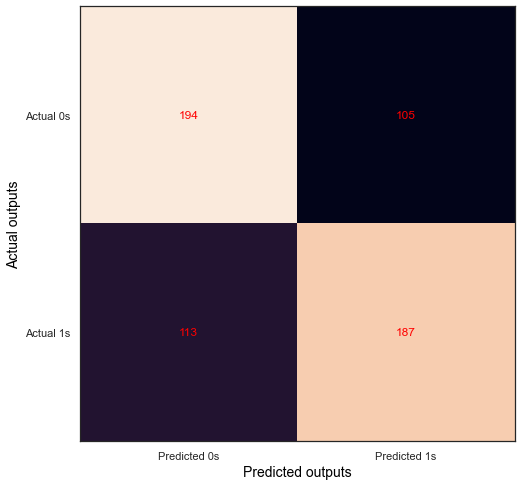

In [256]:
from sklearn.preprocessing import StandardScaler

def logit_regression(df_reg_emotion):
    le_emotion = preprocessing.LabelEncoder()
    df_reg_emotion["flagged"] = le_emotion.fit_transform(df_reg_emotion["flagged"])

    X = df_reg_emotion.drop(columns=["flagged"])
    X = sm.add_constant(X)
    Y = df_reg_emotion["flagged"]

    #scaler = StandardScaler()
    #X = scaler.fit_transform(X)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 1, shuffle=True, stratify=Y)

    model = sm.Logit(Y_train, X_train)
    result = model.fit()
    
    print("\nTrain Accuracy: " + str(sum((result.predict(X_train) >= 0.5).astype(int) == Y_train)/len(Y_train)))
    print("\nTest Accuracy: " + str(sum((result.predict(X_test) >= 0.5).astype(int) == Y_test)/len(Y_test)))
    print(result.summary())
    print(classification_report(Y_test, (result.predict(X_test) >= 0.5).astype(int)))
    cm = confusion_matrix(Y_test, (result.predict(X_test) >= 0.5).astype(int))

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.set_xlabel('Predicted outputs', fontsize=14, color='black')
    ax.set_ylabel('Actual outputs', fontsize=14, color='black')
    ax.xaxis.set(ticks=(0,1),ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0,1),ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

logit_regression(df_final)

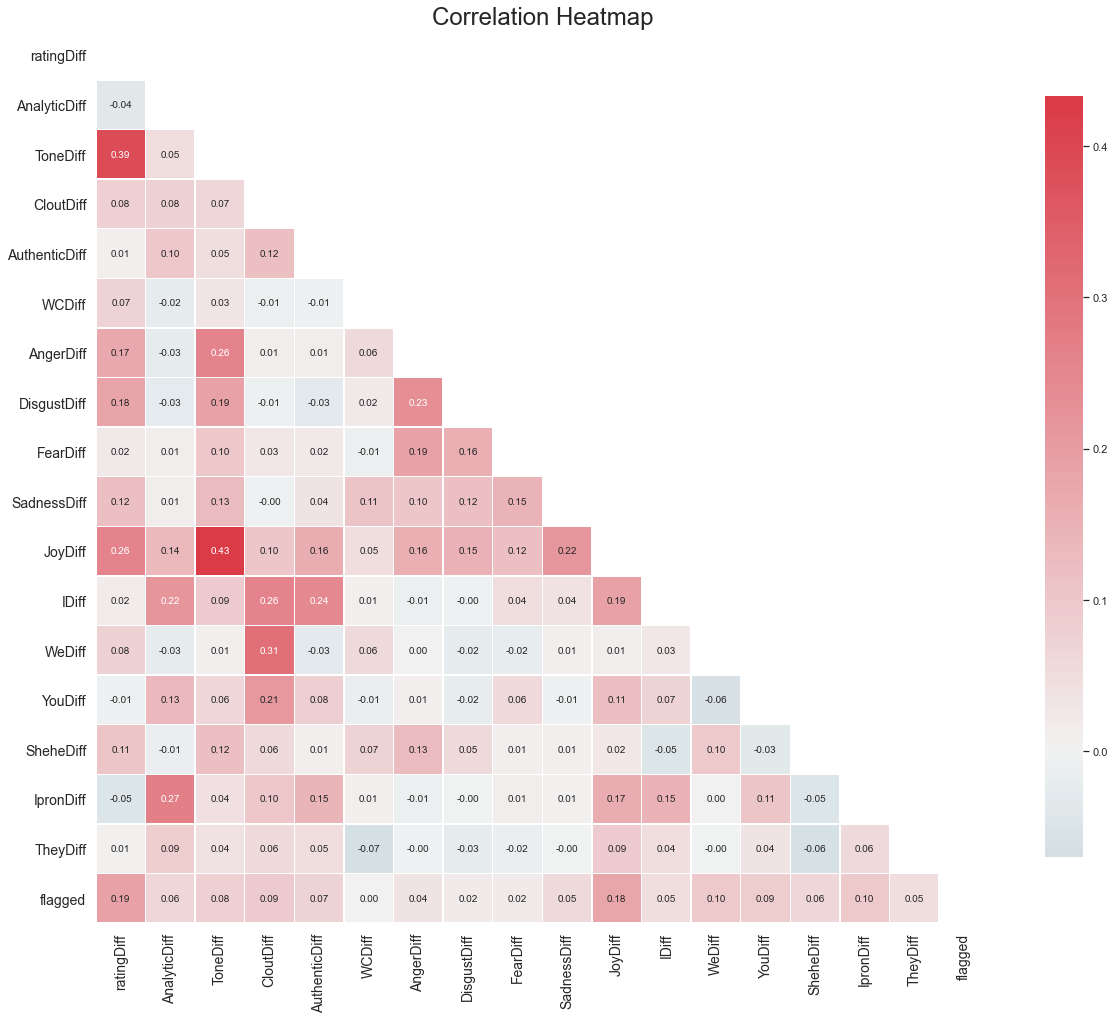

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap(df_fs):
    sns.set(style="white")
    # Calculating Pearson's correlation coefficient of the subsetted data
    correlation = (pd.concat([df_fs.drop(columns=["flagged"]),df_fs["flagged"]], axis=1)).corr()
    mask = np.zeros_like(correlation, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(20,20))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(correlation, center=0, mask=mask,cmap=cmap,
                fmt='.2f', square=True, linewidths=.5, 
                annot=True, cbar_kws={"shrink": .70},  
                annot_kws={"size": 10})
    ax.set_title('Correlation Heatmap', fontsize = 24)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)

    
heatmap(df_final)

In [428]:
X = df_combined.drop(columns=["flagged"])
#X = sm.add_constant(X)
Y = df_combined["flagged"]

#scaler = StandardScaler()
#X = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 1, shuffle=True, stratify=Y)
from sklearn.metrics import accuracy_score

#from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state = 1, n_estimators=500)
#X = feature_selection(X_train,Y_train, 150)

rf_model.fit(X_train, Y_train)
rf_predictions = rf_model.predict(X_test)
acc = accuracy_score(rf_predictions,Y_test)
acc

0.6517336606320957

In [262]:
cleaning_df = pd.read_csv("previous_reviews.csv")
cleaning_df
#cleaning_df.rename(columns={'K':'originalRevID','A': 'date', 'B': 'reviewID', 'C':'reviewerID', 'D': 'review', 'E': 'rating', 'F':'usefulCount', 'G':'coolCount','H':'funnyCount', 'I': 'flagged','J': 'restaurantID'}, inplace=True)
#cleaning_df=cleaning_df.drop(0)

#k=0
for i,row in cleaning_df.iterrows():
#    if (i==161517):
#        print(cleaning_df.at[i,"review"].replace('Â\xa0','').replace('Â\xa0',''))
    #cleaning_df.at[i,"review"] = cleaning_df.at[i,"review"].replace(cleaning_df.at[i,"review"],'Â\xa0','').replace('Â','')
    cleaning_df.at[i,"review"] = cleaning_df.at[i,"review"].replace('Â\xa0','').replace('Â\xa0','')

In [263]:
cleaning_df
#list(cleaning_df["review"])[0].replace('Â\xa0', '')

,date,reviewID,reviewerID,review,rating,usefulCount,coolCount,funnyCount,flagged,restaurantID,originalRevID
0,2009-12-01,ctA2PdCJlF0KeCBsP,EM9qQxKzCbPONjOXbCCQBw,Cheap. Thats the only upside. After living in ...,2,2,0,2,N,tW2jfL-qMccAYZSghPBbHA,XTgVp0QkXUJUnqprblt-3w
1,2009-11-28,jwJTlc8qrBLpkYKt4CGmZg,Gxu8g6IDK5pbM_9ReT8Hmg,Amazing. The most perfect slice of deep dish I...,5,3,2,1,N,tW2jfL-qMccAYZSghPBbHA,XTgVp0QkXUJUnqprblt-3w
2,2009-11-22,1mKFAuJueo4cJ-o0cG3ssA,EQGNWIjSITjGXXWPCUGkDA,"Born and raised in Chicago, and god only knows...",4,0,1,0,N,tW2jfL-qMccAYZSghPBbHA,XTgVp0QkXUJUnqprblt-3w
3,2009-11-20,2J4AE24Wlu5XmeCLQP,MOhA6cDlZ5hRHLuA_WOaDQ,"Yes, Ive indeed tried a lot of pizza. Ive had ...",4,1,0,1,N,tW2jfL-qMccAYZSghPBbHA,XTgVp0QkXUJUnqprblt-3w
4,2009-11-14,OELXVjEu2pxNAuzLJ47hvA,7L2R2hs_VoT2rprrfizUHg,"Yum, I am always in a food coma after eating h...",4,0,0,1,N,tW2jfL-qMccAYZSghPBbHA,XTgVp0QkXUJUnqprblt-3w
...,...,...,...,...,...,...,...,...,...,...,...
161512,2010-02-23,R7zz2M6m0ID,Uy5WS3b2KVZd8lZK1KuEjA,"Very nice service, very accommodating, and a l...",4,2,0,0,N,N7juvW8YoFIj7sEBzVF8GQ,fSKwROK0raZ9ljsxArDmqQ
161513,2010-02-20,J7Qa-m-IGgkrjbPV,c75RjirUA_4wzl47TlZEJQ,Prepare yourself for some amazingly tasty food...,5,4,2,0,N,N7juvW8YoFIj7sEBzVF8GQ,fSKwROK0raZ9ljsxArDmqQ
161514,2010-02-17,HYOeh2hBwD2DK10MV7X1qw,31A0UI-fyZqHu1jxCnB1rg,You're simply the best...better than all the r...,5,1,0,0,N,N7juvW8YoFIj7sEBzVF8GQ,fSKwROK0raZ9ljsxArDmqQ
161515,2010-02-16,-ndgxV3RCKKgIqhhRCfkqQ,XsStxmyaOXC9oXNs9GaJEQ,BYOB! BYOB! BYOB! BYOB! We of course assumed t...,4,1,0,0,N,N7juvW8YoFIj7sEBzVF8GQ,fSKwROK0raZ9ljsxArDmqQ


In [264]:
#cleaning_df.to_csv('previous_reviews.csv', index=False)


In [61]:
df_emotion = pd.read_csv("time_adjusted_LIWC_and_emotions.csv")
#df_emotion

,reviewID,sadness,anger,disgust,joy,fear,date,reviewerID,review,rating,...,see,hear,feel,swear,netspeak,assent,nonflu,filler,QMark,Exclam
0,ctA2PdCJlF0KeCBsP,0.292643,0.112365,0.088567,0.261127,0.109580,2009-12-01,EM9qQxKzCbPONjOXbCCQBw,Cheap. Thats the only upside. After living in ...,2,...,0.00,0.00,0.00,0.0,3.45,0.00,0.00,0.0,0.00,0.00
1,jwJTlc8qrBLpkYKt4CGmZg,0.542694,0.076944,0.616414,0.662569,0.069506,2009-11-28,Gxu8g6IDK5pbM_9ReT8Hmg,Amazing. The most perfect slice of deep dish I...,5,...,0.90,0.00,0.90,0.0,0.00,0.00,0.90,0.0,0.00,0.00
2,1mKFAuJueo4cJ-o0cG3ssA,0.025798,0.022255,0.006346,0.939005,0.008607,2009-11-22,EQGNWIjSITjGXXWPCUGkDA,"Born and raised in Chicago, and god only knows...",4,...,0.00,0.00,0.00,0.0,1.67,0.00,0.00,0.0,0.00,1.67
3,2J4AE24Wlu5XmeCLQP,0.157338,0.047234,0.079734,0.621915,0.065345,2009-11-20,MOhA6cDlZ5hRHLuA_WOaDQ,"Yes, Ive indeed tried a lot of pizza. Ive had ...",4,...,1.35,1.35,0.00,0.0,0.00,2.03,0.00,0.0,0.68,0.00
4,OELXVjEu2pxNAuzLJ47hvA,0.104872,0.046039,0.041377,0.731628,0.034957,2009-11-14,7L2R2hs_VoT2rprrfizUHg,"Yum, I am always in a food coma after eating h...",4,...,0.00,0.00,3.45,0.0,0.00,0.00,0.00,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29100,LNtM0Zg7QFwBq6kuLUcqUg,0.165529,0.116166,0.057548,0.691710,0.067401,2009-12-04,BkZWHgKCwNc-9aJoLF0mUQ,"Warm it up, Kris...Im about to.... I have been...",4,...,1.33,0.00,1.33,0.0,0.00,0.00,0.67,0.0,0.00,0.00
29101,-2nm,0.425518,0.062322,0.073516,0.720362,0.068419,2009-11-20,AftFelF-uWV83h4nKTFawQ,This is not like Fogo or texas de brasil. It h...,3,...,0.78,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00
29102,5PiI8LiADzTjpLzUClz93Q,0.089564,0.087011,0.420219,0.688732,0.086729,2009-11-20,OCTep1VhmZ05l6FpiVhuUg,"I love this place. As far as rooftop bars go, ...",4,...,1.48,0.74,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00
29103,Ux9W4Y7w18lOtlc5igdTig,0.484980,0.067052,0.441654,0.671243,0.079364,2009-11-16,QOm-8-jt181pIoYPfJXMeA,Zed 451 is a cool hip looking placed but if yo...,3,...,1.97,0.79,0.79,0.0,0.00,0.79,0.00,0.0,0.00,0.39


# Combined model

/Users/jamesfyfe/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/jamesfyfe/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Optimization terminated successfully.
         Current function value: 0.617924
         Iterations 5

Train Accuracy: 0.6584551148225469

Test Accuracy: 0.6510851419031719
                           Logit Regression Results                           
Dep. Variable:                flagged   No. Observations:                 2395
Model:                          Logit   Df Residuals:                     2365
Method:                           MLE   Df Model:                           29
Date:                Mon, 01 Feb 2021   Pseudo R-squ.:                  0.1085
Time:                        20:53:20   Log-Likelihood:                -1479.9
converged:                       True   LL-Null:                       -1660.1
Covariance Type:            nonrobust   LLR p-value:                 7.575e-59
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                

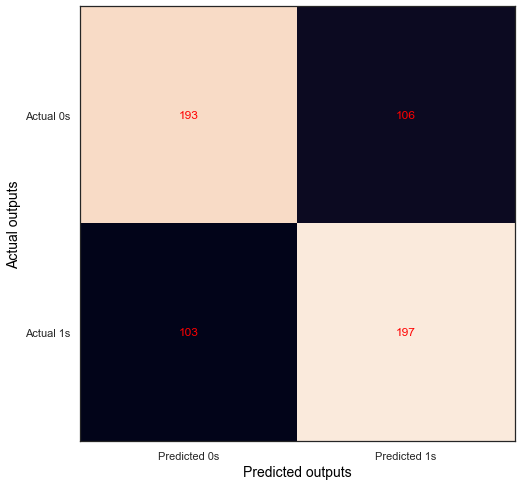

In [298]:
####### with summary vars only #############
df_final=df_combined[[#"ratingDiff",
                         "AnalyticDiff","ToneDiff","CloutDiff","AuthenticDiff","WCDiff",
                         "flagged",
                         'IDiff','WeDiff',"YouDiff","SheheDiff","IpronDiff","TheyDiff",
                         "Tone","Analytic","Clout","Authentic",
                         "AngerDiff","DisgustDiff","FearDiff","SadnessDiff","JoyDiff",
                         "WC", "rating","OriginalRatingDiff",
                         "i","we","you","shehe","ipron","they"
                       #  "anger","disgust","sadness","joy","fear"
                        ]]

df_final["OriginalRatingDiff"]=df_final["OriginalRatingDiff"]
logit_regression(df_final)

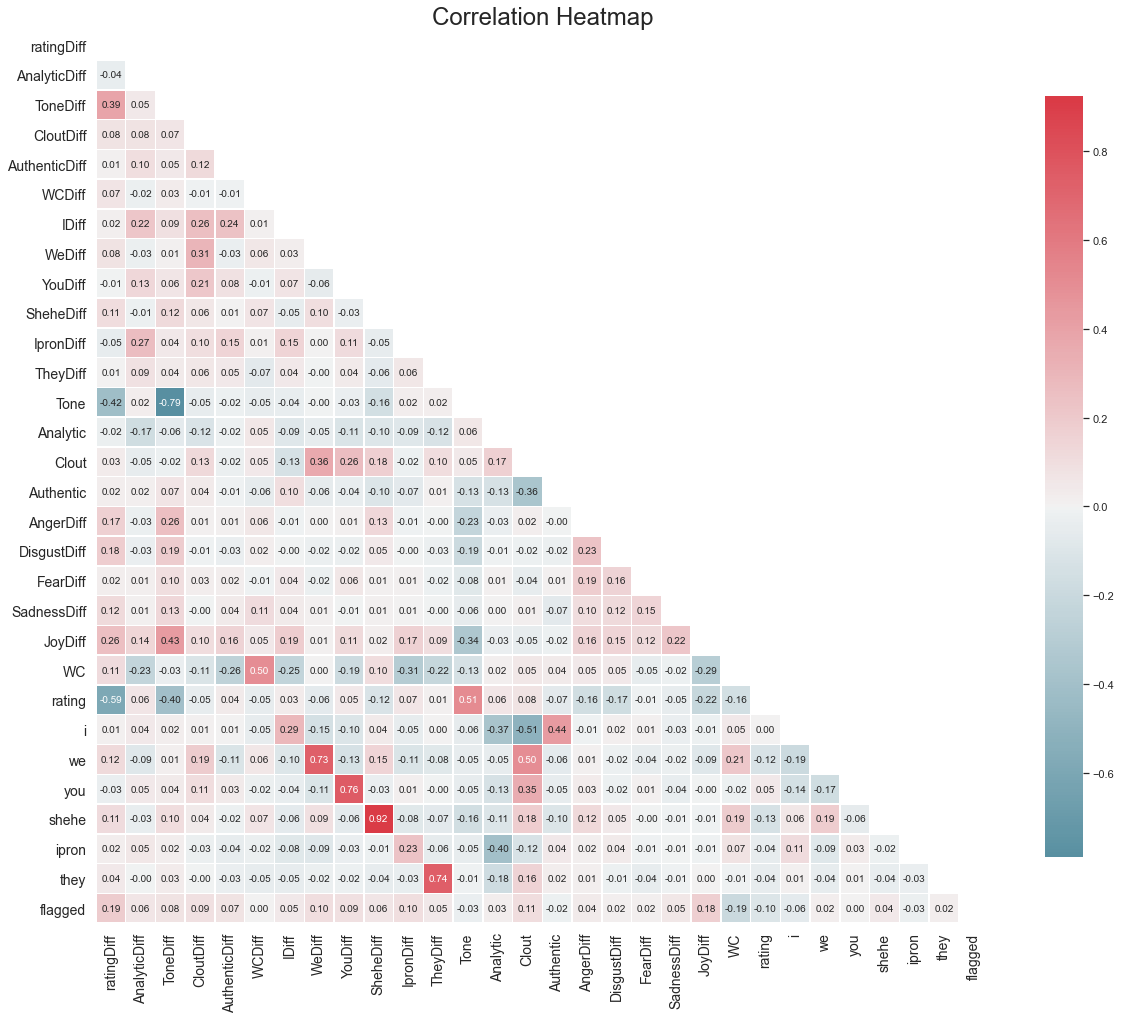

In [284]:
heatmap(df_final)

# KNN

In [313]:
from sklearn.feature_selection import SelectKBest, f_classif

# this feature selection step performs a univariate linear regression between salary 
# and each feature and calculates the p value, selecting k most significant features
# a good way to start by culling the least significant features
def feature_selection(X,Y,k):
    selector = SelectKBest(f_classif, k=k)
    feature_data = selector.fit_transform(X, Y)
    mask=selector.get_support()
    feature_names = X.columns[mask]
    df_selected = pd.DataFrame(feature_data, columns=feature_names)
    return df_selected



In [324]:
scaler = StandardScaler()
names = df_final.columns
df_scaled = scaler.fit_transform(df_final) 
df_scaled = pd.DataFrame(df_scaled, columns=names)



In [338]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier


X = df_scaled.drop(columns=['flagged'])
Y = df_scaled['flagged']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 1, shuffle=True, stratify=Y)

feature_list = list(range(1,30)) # try 40 features max
k_list=list(range(1,30))
cv_acc_array = [] # to plot acc for different number of features and neighbours
train_acc_array = []
kf=KFold(10, shuffle=True, random_state=1) # six folds with row shuffle
test_acc_array = []
cv_acc_features = []


for n in feature_list:
    train = feature_selection(X_train,Y_train,n)
    test = X_test[train.columns]
    
    cv_acc_k = []
    cv_best_score = -np.inf # cross-validation score
    best_knn = None # best model according cross validation

    for k in k_list:
        knn_1 = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn_1, train, Y_train, cv=kf, scoring = 'accuracy')
        # the average score across 10 folds
        cv_score = np.mean(scores)
        cv_acc_k.append(cv_score)
        
        if cv_score >= cv_best_score:
            cv_best_score = cv_score
            best_knn = knn_1
    
    cv_acc_array.append(cv_acc_k)
    # we have selected the best model for that number of features    
    knn = best_knn
    # train the selected model with the whole train set
    knn.fit(train, Y_train)
    # Predict the test data with the selected and re-estimated model
    predictions = knn.predict(test)
    predictions_train = knn.predict(train)
    
    #print(predictions)
    test_acc = sum(Y_test == (predictions).astype(int))/(len(Y_test))
    test_acc_array.append(test_acc)
    
    train_acc = sum(Y_train == (predictions_train).astype(int))/(len(Y_train))
    train_acc_array.append(train_acc)
    
    cv_acc= cv_best_score
    cv_acc_features.append(cv_acc)
    print("Features: "+str(n)+", Test acc: "+str(test_acc)+", CV acc: "+str(cv_acc)+", Train acc: "+str(train_acc)+", k: "+str(knn.n_neighbors))   
    
    

Features: 1, Test acc: 0.5308848080133556, CV acc: 0.5978957461645746, Train acc: 0.6275574112734864, k: 25
Features: 2, Test acc: 0.6227045075125208, CV acc: 0.6150505578800558, Train acc: 0.6551148225469728, k: 26
Features: 3, Test acc: 0.6210350584307178, CV acc: 0.6325714783821478, Train acc: 0.6605427974947808, k: 24
Features: 4, Test acc: 0.6060100166944908, CV acc: 0.6354898884239888, Train acc: 0.6743215031315241, k: 22
Features: 5, Test acc: 0.5759599332220368, CV acc: 0.6392677824267783, Train acc: 0.6697286012526096, k: 29
Features: 6, Test acc: 0.5876460767946577, CV acc: 0.6292555788005579, Train acc: 0.6705636743215031, k: 29
Features: 7, Test acc: 0.5859766277128547, CV acc: 0.6267311715481172, Train acc: 0.6634655532359082, k: 29
Features: 8, Test acc: 0.5826377295492488, CV acc: 0.620465481171548, Train acc: 0.6617954070981211, k: 28
Features: 9, Test acc: 0.6227045075125208, CV acc: 0.6317294281729429, Train acc: 0.6651356993736952, k: 29
Features: 10, Test acc: 0.612

In [320]:
X_train

,AnalyticDiff,ToneDiff,CloutDiff,AuthenticDiff,WCDiff,IDiff,WeDiff,YouDiff,SheheDiff,IpronDiff,...,JoyDiff,WC,rating,OriginalRatingDiff,i,we,you,shehe,ipron,they
1197,29.347000,16.927000,14.696000,25.549000,121.200000,1.253000,2.510000,0.718,0.738000,1.038000,...,0.010294,60,5,1.0,6.67,0.00,0.00,0.00,5.00,1.67
820,59.204000,55.395000,41.939000,67.752000,168.700000,3.957000,0.726000,0.186,0.523000,18.297000,...,0.537648,13,2,2.0,7.69,0.00,0.00,0.00,23.08,0.00
1307,26.198000,4.844000,9.968000,5.014000,52.400000,0.690000,0.847000,0.792,0.360000,0.715000,...,0.042440,196,2,1.5,4.59,0.00,2.55,0.51,5.61,0.00
1467,10.770000,59.495000,42.929000,5.809000,59.900000,3.212000,3.005000,0.251,2.504000,2.196000,...,0.154185,254,4,0.0,2.36,4.72,0.79,2.76,7.48,0.79
958,12.712000,4.274000,20.848000,21.795000,112.400000,0.676000,1.800000,0.193,0.095000,0.882000,...,0.117064,87,4,0.5,3.45,0.00,1.15,0.00,5.75,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,19.963000,26.525000,22.470000,19.468000,78.000000,2.948000,2.220000,0.775,0.429000,1.253000,...,0.126465,96,4,0.0,7.29,0.00,0.00,0.00,5.21,0.00
1435,38.615000,12.853000,36.736000,46.854000,103.500000,7.225000,0.948000,0.465,0.255000,0.838000,...,0.021153,33,4,0.5,12.12,0.00,0.00,0.00,6.06,0.00
1532,27.867778,17.457778,26.578889,26.206667,123.666667,2.188889,0.373333,1.030,0.045556,3.201111,...,0.016276,250,5,1.5,2.00,2.40,1.20,0.00,2.80,0.00
2663,22.661000,7.813000,1.854000,19.454000,13.300000,2.751000,1.380000,0.448,0.428000,2.291000,...,0.010237,107,4,0.0,2.80,2.80,0.00,0.00,3.74,0.93


In [318]:
Y_train

1197    0
820     0
1307    1
1467    0
958     0
       ..
2002    1
1435    0
1532    0
2663    0
2943    1
Name: flagged, Length: 2395, dtype: int64